In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import datetime 
import pandas_datareader as pdr
import pandas_ta as ta


In [2]:
# data = dataframe in pandas format to calculate sma
# sma_value = is an array to calcuate the lenth of sma 
# variable = variable used to calculate sma, it can be a "Close", or "Adj Close" in string format
def sma(data,sma_value,variable):
     # auto assign a variable name based on length of sma 
    variable_name = 'SMA'+ str(sma_value)
    # calculate sma 
    data[variable_name] =ta.sma(data[variable], length=sma_value)
    # return sma variable calculated 
    return data[variable_name]
# sym =  string format, ticker name
# ema value = is an array to calcuate the lenth of ema 
# sma_value = is an array to calcuate the lenth of sma 
# close = variable use for calcuate sma and ema, either "Close"or "Adj Close" in string format
def getdata(sym,sma_value,close):
    today = datetime.datetime.now()
    df = pdr.get_data_yahoo(sym, start=datetime.datetime(today.year-5,today.month, 1),
                                    end=datetime.datetime(today.year, today.month, today.day)).reset_index()
    df['ticker'] =sym
        
    for i in sma_value:
        variable_name = 'SMA'+ str(i)
        df[variable_name] = sma(df,i,close)
    return df

In [3]:
def Generate_signal(data):    
    #table start
    df_init =  data.copy()
    
    '''To make sure row arrange in an ascending order'''
    df_init.sort_values(by = 'Date',inplace=True)
    
    '''Process data by remove Null value in moving average varaible that your want to used for triggered''' 
    df_init.dropna(subset=['SMA200'],inplace=True)
    '''generate as 1 if Adj close is higher than variable you want to test, generate as -1 if Adj close is less than the
    variable you want to test in a signal variable  
    '''
    # create a signal variable
    df_init['signal'] = np.nan
    # trigger a buy only if it is a up trend 
    #df_init.loc[(data['macd'] > data['macd_signal_line']) & (data['Close'] > data['SMA20'])& (data['SMA20'] > data['SMA200']) ,'signal'] = 1
    df_init.loc[((data['macd'] > data['macd_signal_line']) & (data['Close'] > data['SMA60'])) ,'signal'] = 1
    # just triggered sell as close is less than variable triggered
    #df_init.loc[(data['macd'] <  data['macd_signal_line']) & (data['Close'] < data['SMA20'])| (data['SMA20'] < data['SMA200']),'signal'] = -1
    #df_init.loc[(data['macd'] < data['macd_signal_line']) ,'signal'] = -1
    #df_init.loc[(data['SMA20'] < data['SMA50']) ,'signal'] = -1
    
    #df_init.loc[(data['RSI'] > 80)| (data['SMA15'] < data['SMA50'])| (data['Bearish_engulfing']==True) |(data['Bearish_pinbar']==True),'signal'] = -1
    df_init.loc[(data['RSI'] >70)| (data['SMA15'] < data['SMA20'])| (data['Bearish_engulfing']==True),'signal'] = -1

    #df_init.loc[(data['RSI'] > 80)| (data['SMA15'] < data['SMA20']),'signal'] = -1
    #df_init.loc[data['Close'] < data['SMA20'] ,'signal'] = -1
    # if close > variable triggered but sma20<= sma 200, let it be do nothing
    df_init.fillna(0,inplace=True)
    
    ''' move the signal of today to tmr, thus, we need to define a shift(1), as the signal buy is based on yesterday'''
    df_init['signal'] = df_init['signal'].shift(1)
    
    '''after we have a buy and sell signal, lets create a hold signal which is equal to 2 after a buy signal and
    a do nothing signal which is equal to 0 after a sell signal'''
    
    # In order to make a decision on a hold or do nothing signal based on yesterday signal we need to create a for loop 
    # a calendar date should be created to used for a a for loop 
    date_list = df_init.Date.unique()
    
    # declare a first day, the first date is a null in signal as there is no yesterday data for first data
    first_date = date_list[0]
    
    # declare a previous day 
    prev = first_date 
    
    for i in date_list:
        if i == first_date:
            df_init.loc[df_init.Date == i,'signal'] = 0 
        else:
            # if you have a sell signal yesterday, you should have a do nothing signal today
            if (df_init.loc[df_init.Date == prev,'signal'].values[0]==-1):
                df_init.loc[df_init.Date == i,'signal']=0 
            # if you have a buy signal yesterday, you should have a hold signal today
            elif (df_init.loc[df_init.Date == prev,'signal'].values[0]==1):
                df_init.loc[df_init.Date == i,'signal'] = 2
              
            # if you have a hold signal yesterday and you do not have a sell signal today, you should have a hold signal today
            elif ((df_init.loc[df_init.Date == prev,'signal'].values[0]==2)&(df_init.loc[df_init.Date == i,'signal'].values[0]!=-1) ):
                df_init.loc[df_init.Date == i,'signal'] = 2
                
            # if you have a do nothing signal yesterday and today is a sell signal, you should equal to have a do nothing signal
            elif ((df_init.loc[df_init.Date == prev,'signal'].values[0]==0)&(df_init.loc[df_init.Date == i,'signal'].values[0]==-1) ):
                df_init.loc[df_init.Date == i,'signal'] = 0
                
        # redeclare your previous date before to next day in for loop
        prev = i
    
    return df_init
    

In [56]:
from statistics import mean
def backtest_strategy(data,capital, result_data):   
    
    #table start
    df_init =  data.copy()
    df_init.set_index('Date',inplace=True) 
    
    #assign dummy row - day before the trade
    start_date = pd.DataFrame(columns=data.columns,index=[df_init.index.min()- datetime.timedelta(days=1)])
    df_init = df_init.append(start_date)
    
    #initiat 2 variable: cash and units which represent each status of cash and units of apple holding for each day
    df_init = df_init.assign(cash=np.nan,units = 0)
    
    #assign capital for first dummy day assigned to be capital defined in function
    df_init.loc[pd.Series(df_init.index.min()), 'cash'] = capital
    
    # obtain list of calendar 
    calendar = pd.Series(df_init.index.sort_values().unique()).iloc[1:]
    
    ''' assign a variable which is trade, earn trade and lost trade to calculate total number of trade, total earn trade 
    and total lost trade'''
    trade = 0
    earn_trade = 0
    loss_trade = 0
    
    ''' create an array to keep all earn value and lost value for each trade'''
    earn_value =[]
    lost_value =[]

    for date in calendar:
        
        #get yesterday data
        prev_date = df_init.index[df_init.index<date].unique().sort_values()[-1]
        
        # calculate total stock value of yesterday 
        stock_holding = df_init.loc[(df_init.index==prev_date), 'units'].values[0]*df_init.loc[(df_init.index==date),'Price'].values[0]
        
        # total portfolio value by add cash and stock value of yesterday 
        port_value = stock_holding + df_init.loc[prev_date, 'cash'].sum()
        
        
        # if signal is do nothing, mean our cash = portfolio value and units=0
        if df_init.loc[(df_init.index==date), 'signal'].values[0] == 0:          
            df_init.loc[(df_init.index==date), 'units'] = 0
            df_init.loc[(df_init.index==date), 'cash'] =port_value        
        #if we have a buy signal 
        #start to calculate the trade
        #we start to calculate start_cap which represent the starting capital for each trade
        #unit_buy is total unit buy based on port_value available
        elif df_init.loc[(df_init.index==date), 'signal'].values[0] == 1:
            trade+=1
            start_cap = port_value 
            unit_buy = port_value/df_init.loc[(df_init.index==date), 'Price'].values[0]
            df_init.loc[(df_init.index==date), 'units'] = unit_buy
            df_init.loc[(df_init.index==date), 'cash'] = port_value - unit_buy*df_init.loc[(df_init.index==date), 'Price'].values[0]        
#             df_init.loc[(df_init.index==date), 'CL_price'] = df_init.loc[(df_init.index==date), 'Price'].values[0] * 0.95
#             df_init.loc[(df_init.index==date), 'CL_based_price'] = df_init.loc[(df_init.index==date), 'Price'].values[0]
        #if we have a hold signal or do nothing signal,
        #mean today units hold and cash are same as yesterday units hold and yesterday cash
        elif ((df_init.loc[(df_init.index==date), 'signal'].values[0] == 2) | (df_init.loc[(df_init.index==date), 'signal'].values[0] == 0)): 
            df_init.loc[(df_init.index==date), 'units'] = df_init.loc[(df_init.index==prev_date), 'units'].values[0]
            df_init.loc[(df_init.index==date), 'cash'] =df_init.loc[(df_init.index==prev_date), 'cash'].values[0]
#             if  df_init.loc[(df_init.index==date), 'Price'].values[0] > df_init.loc[(df_init.index==prev_date), 'CL_based_price'].values[0]:
#                 df_init.loc[(df_init.index==date), 'CL_price'] = df_init.loc[(df_init.index==date), 'Price'].values[0] * 0.95
#                 df_init.loc[(df_init.index==date), 'CL_based_price'] = df_init.loc[(df_init.index==date), 'Price'].values[0]
#             else:
#                 df_init.loc[(df_init.index==date), 'CL_price'] = df_init.loc[(df_init.index==prev_date), 'CL_price'].values[0]
#                 df_init.loc[(df_init.index==date), 'CL_based_price'] =  df_init.loc[(df_init.index==prev_date), 'CL_based_price'].values[0]
        #if we have a sell signal,
        #1. we sell all the units at the today open price and thus units =0 and cash = port_value
        #2. we calculate the total earn/lost of this trade by using port_value - start cap of the trade and store as v variable
        #3. if v> 0, we store as earn_value array
        #4. if v<0, we store as lost trade
        elif (df_init.loc[(df_init.index==date), 'signal'].values[0] == -1) :
            df_init.loc[(df_init.index==date), 'units'] = 0
            df_init.loc[(df_init.index==date), 'cash'] =port_value 
            if (start_cap is None):
                0
            else:
                v = port_value  - start_cap 
                if v> 0: 
                    earn_value.append(v)
                    earn_trade +=1
                elif v<0: 
                    lost_value.append(v)
                    loss_trade+=1

    # calculate current value of the strategy, the formula = unit holding * Price + cash available
    df_init['Total_value_todate'] = df_init['units']*df_init['Price'] + df_init['cash'] 
    
    # append 0 to earn value array to prevent later calculation fail if there is no any earn trade
    earn_value.append(0)
    #remove dummy rows
    df_init.drop(df_init[df_init.index == df_init.index.min()].index,axis=0,inplace=True)
  
    # get summarize of total portfolio value, return by date, benchmark_index
    total_port_value = pd.DataFrame(df_init.groupby([df_init.index])['Total_value_todate'].sum())
    total_port_value['Return_without_trailing'] = total_port_value['Total_value_todate']/total_port_value['Total_value_todate'].iloc[0] *100
    total_port_value['Return_trailing_12m'] = total_port_value['Total_value_todate']/total_port_value['Total_value_todate'].shift(12)*100

    # to print out statistic to know how your strategy perform and the win change of this strategy
    print('total_trade:',trade)
    print('earn_trade:',earn_trade)
    print('lost_trade:',loss_trade)
    print('win_chance:',earn_trade/trade)
    print('Max earning:',max(earn_value))
    print('Max lost:',min(lost_value))
    print('Average lost:',mean(lost_value))
    print('Average Win:',mean(earn_value))
    # Create a dictionary with the data for the new data frame
    data = {
        'ticket': [data.ticker.values[0]],
        'total_trade' : [trade],
        'Average Win': [mean(earn_value)],
        'Average lost' :  [mean(lost_value)],
        'win_chance': [earn_trade/trade]
    }

    # Create the new data frame
    df = pd.DataFrame(data)
    result_data =  pd.concat([df , result_data])
    return total_port_value, df_init,result_data

In [57]:
# annualized return 
# df =data with return 
# variable = variable name of return
def annualized(df,variable):
    days_held =df.shape[0]
    Return = (df.iloc[-1][variable] - df.iloc[0][variable])/df.iloc[0][variable]
    ar = ((1+Return) ** (365/days_held))-1
    # get annualized in %
    return ar*100
# maximum drawdown 
# df =data with return 
# variable = variable name of return
def MDD(df,variable):
    window = 252
    Roll_Max = df[variable].rolling(window, min_periods=1).max()
    Drawdown = df[variable]/Roll_Max - 1.0
    mdd = Drawdown.min()
    # get drawdown in %
    return mdd*100

In [58]:
# Function to calculate RSI
def RSI(prices, n=14):
  # Get the difference in price from previous step
    delta = prices.diff()

  # Get rid of the first row, which is NaN since it did not have a previous
  # row to calculate the differences
    delta = delta[1:]

  # Make the positive gains (up) and negative gains (down) Series
    up, down = delta.copy(), delta.copy()
    up[up < 0] = 0
    down[down > 0] = 0

  # Calculate the SMA
    roll_up = up.rolling(n).mean()
    roll_down = down.abs().rolling(n).mean()

  # Calculate the RSI based on SMA
    RS = roll_up / roll_down
    RSI = 100.0 - (100.0 / (1.0 + RS))

    return RSI

# Function to calculate macd
def macd(df):
    data=df.copy()
    macd_short = 12  # The window size for the MACD's short-term moving average
    macd_long = 26   # The window size for the MACD's long-term moving average
    macd_signal = 9  # The window size for the MACD's signal line
    # Calculate the MACD
    data['macd'] = data['Close'].ewm(span=macd_short).mean() - data['Close'].ewm(span=macd_long).mean()


    # Calculate the MACD signal line
    data['macd_signal_line'] = data['macd'].ewm(span=macd_signal).mean()
    return data 

In [61]:
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
df = table[0]
ticker = df['Symbol'].values
result_data = pd.DataFrame()

In [62]:
# for i in ticker:
#     print(i)
#     data = getdata(i,sma_value = [15,20,30,50,60,120,200],close = "Close")
#     # get candle stick of bearish engulfing
#     data['Bearish_engulfing'] = np.nan
#     for i in range(2,data.shape[0]):
#         current = data.iloc[i,:]
#         prev = data.iloc[i-1,:]
#         prev_2 = data.iloc[i-2,:]
#         realbody = abs(current['Open'] - current['Close'])
#         candle_range = current['High'] - current['Low']
#         idx = data.index[i]
#         data.loc[idx,'Bearish_engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] < current['Open']
#     data['RSI'] = RSI(data['Close'])
#     data  = macd(data)
#     # Get signal
#     df_signal = Generate_signal(data)
#     # back test your strategy using Open price as price action to buy sell on particular day
#     df_signal['Price']=df_signal['Open']
#     df_backtest = df_signal[['Date','Price','signal','Open','ticker']].copy()
#     result, hold_detail,result_data = backtest_strategy(df_backtest,1000,result_data)


In [76]:
len(result_data.ticket.unique())

500

In [63]:
for i in ticker:
    # Read in the data
    try:
        print(i)
        data = getdata(i,sma_value = [15,20,30,50,60,120,200],close = "Close")
        # get candle stick of bearish engulfing
        data['Bearish_engulfing'] = np.nan
        for i in range(2,data.shape[0]):
            current = data.iloc[i,:]
            prev = data.iloc[i-1,:]
            prev_2 = data.iloc[i-2,:]
            realbody = abs(current['Open'] - current['Close'])
            candle_range = current['High'] - current['Low']
            idx = data.index[i]
            data.loc[idx,'Bearish_engulfing'] = current['High'] > prev['High'] and current['Low'] < prev['Low'] and realbody >= 0.8 * candle_range and current['Close'] < current['Open']
        data['RSI'] = RSI(data['Close'])
        data  = macd(data)
        # Get signal
        df_signal = Generate_signal(data)
        # back test your strategy using Open price as price action to buy sell on particular day
        df_signal['Price']=df_signal['Open']
        df_backtest = df_signal[['Date','Price','signal','Open','ticker']].copy()
        result, hold_detail,result_data = backtest_strategy(df_backtest,1000,result_data)
    except:
        pass # doing nothing on exception

MMM
total_trade: 40
earn_trade: 20
lost_trade: 20
win_chance: 0.5
Max earning: 36.947338357486046
Max lost: -122.92831276242896
Average lost: -33.99142601591163
Average Win: 16.13468051901599
AOS
total_trade: 39
earn_trade: 23
lost_trade: 16
win_chance: 0.5897435897435898
Max earning: 123.05521667420464
Max lost: -112.94119698660711
Average lost: -44.68240195170388
Average Win: 30.227950033287083
ABT
total_trade: 43
earn_trade: 22
lost_trade: 20
win_chance: 0.5116279069767442
Max earning: 105.42685497212301
Max lost: -116.51912887654248
Average lost: -42.212694336156645
Average Win: 30.964944586893417
ABBV
total_trade: 33
earn_trade: 19
lost_trade: 14
win_chance: 0.5757575757575758
Max earning: 93.03525759451645
Max lost: -95.57122716184358
Average lost: -25.28044333708537
Average Win: 28.083931490877916
ABMD
total_trade: 31
earn_trade: 18
lost_trade: 13
win_chance: 0.5806451612903226
Max earning: 95.5960561246726
Max lost: -186.89530774991135
Average lost: -63.17572302518867
Average W

total_trade: 46
earn_trade: 23
lost_trade: 22
win_chance: 0.5
Max earning: 98.73360467023224
Max lost: -116.15638506209007
Average lost: -39.281652508909964
Average Win: 35.30317512791611
ANSS
total_trade: 46
earn_trade: 27
lost_trade: 19
win_chance: 0.5869565217391305
Max earning: 98.22106606780119
Max lost: -217.51652384596036
Average lost: -45.473547550324334
Average Win: 26.691064498394166
AON
total_trade: 41
earn_trade: 30
lost_trade: 11
win_chance: 0.7317073170731707
Max earning: 105.9840432313365
Max lost: -116.50365799236499
Average lost: -40.521808262166026
Average Win: 30.72357112756534
APA
total_trade: 37
earn_trade: 24
lost_trade: 13
win_chance: 0.6486486486486487
Max earning: 173.88602992117603
Max lost: -171.01215445182584
Average lost: -85.70042371797209
Average Win: 62.55281003027533
AAPL
total_trade: 43
earn_trade: 28
lost_trade: 15
win_chance: 0.6511627906976745
Max earning: 101.52703724473099
Max lost: -126.91491965179785
Average lost: -37.849555125824835
Average Win

total_trade: 33
earn_trade: 23
lost_trade: 10
win_chance: 0.696969696969697
Max earning: 284.5312169973936
Max lost: -297.5120666639484
Average lost: -130.4899601736065
Average Win: 84.66711803382381
CPT
total_trade: 42
earn_trade: 23
lost_trade: 18
win_chance: 0.5476190476190477
Max earning: 48.12960376202602
Max lost: -134.1308510769436
Average lost: -37.069698221590194
Average Win: 21.03585750053108
CPB
total_trade: 46
earn_trade: 22
lost_trade: 24
win_chance: 0.4782608695652174
Max earning: 73.06800371619352
Max lost: -174.038768624947
Average lost: -27.044634517815357
Average Win: 25.825828283282853
COF
total_trade: 41
earn_trade: 23
lost_trade: 18
win_chance: 0.5609756097560976
Max earning: 180.13955792630713
Max lost: -193.9436143459343
Average lost: -47.419163499224425
Average Win: 56.02271248343297
CAH
total_trade: 36
earn_trade: 21
lost_trade: 15
win_chance: 0.5833333333333334
Max earning: 95.94934419474896
Max lost: -129.4080515227164
Average lost: -51.07074013463033
Average

total_trade: 29
earn_trade: 22
lost_trade: 7
win_chance: 0.7586206896551724
Max earning: 81.3843552839262
Max lost: -152.51654380866285
Average lost: -57.72967893904979
Average Win: 27.40463696176032
STZ
total_trade: 44
earn_trade: 22
lost_trade: 21
win_chance: 0.5
Max earning: 96.78119208890178
Max lost: -97.49386798508885
Average lost: -30.29808782139936
Average Win: 26.06052829826176
CEG
total_trade: 2
earn_trade: 1
lost_trade: 0
win_chance: 0.5
Max earning: 72.24208795305276
COO
total_trade: 41
earn_trade: 21
lost_trade: 19
win_chance: 0.5121951219512195
Max earning: 116.36660433241946
Max lost: -87.55643630379154
Average lost: -28.88048356499809
Average Win: 34.14327071194478
CPRT
total_trade: 34
earn_trade: 25
lost_trade: 8
win_chance: 0.7352941176470589
Max earning: 102.27034008153487
Max lost: -107.54092283228647
Average lost: -44.747871306310984
Average Win: 33.2910573226768
GLW
total_trade: 26
earn_trade: 14
lost_trade: 12
win_chance: 0.5384615384615384
Max earning: 56.681710

total_trade: 43
earn_trade: 27
lost_trade: 16
win_chance: 0.627906976744186
Max earning: 129.74388933029377
Max lost: -142.28126580465437
Average lost: -49.73876245036434
Average Win: 28.30940599519527
EIX
total_trade: 29
earn_trade: 19
lost_trade: 9
win_chance: 0.6551724137931034
Max earning: 140.92411201393793
Max lost: -152.65465290599718
Average lost: -57.28636535459762
Average Win: 39.88144432651111
EW
total_trade: 42
earn_trade: 25
lost_trade: 17
win_chance: 0.5952380952380952
Max earning: 107.63357633986993
Max lost: -141.33003997766298
Average lost: -58.26278643911156
Average Win: 39.96592573895061
EA
total_trade: 39
earn_trade: 22
lost_trade: 17
win_chance: 0.5641025641025641
Max earning: 50.40416769149192
Max lost: -105.9230818032222
Average lost: -39.12729294495593
Average Win: 22.030471834802913
ELV
total_trade: 35
earn_trade: 21
lost_trade: 14
win_chance: 0.6
Max earning: 70.23493580926856
Max lost: -92.28309514748287
Average lost: -42.43836621377318
Average Win: 19.934733

total_trade: 39
earn_trade: 27
lost_trade: 12
win_chance: 0.6923076923076923
Max earning: 181.4380189300955
Max lost: -163.89138361919936
Average lost: -55.89316912472295
Average Win: 33.376924333660206
FOXA
total_trade: 30
earn_trade: 12
lost_trade: 17
win_chance: 0.4
Max earning: 89.60251221240742
Max lost: -109.99525533334622
Average lost: -25.911038100378565
Average Win: 29.221344021692623
FOX
total_trade: 26
earn_trade: 10
lost_trade: 15
win_chance: 0.38461538461538464
Max earning: 71.28154314813605
Max lost: -139.61457244447104
Average lost: -31.7044167023697
Average Win: 23.885414794978654
BEN
total_trade: 42
earn_trade: 24
lost_trade: 17
win_chance: 0.5714285714285714
Max earning: 170.83300555648748
Max lost: -154.51475843015942
Average lost: -56.6385042469583
Average Win: 38.95723945607297
FCX
total_trade: 39
earn_trade: 23
lost_trade: 15
win_chance: 0.5897435897435898
Max earning: 621.591995896441
Max lost: -424.70170911466585
Average lost: -123.42292136093083
Average Win: 12

total_trade: 40
earn_trade: 27
lost_trade: 13
win_chance: 0.675
Max earning: 134.3838969918529
Max lost: -155.80912533701598
Average lost: -71.43622172154014
Average Win: 43.175814371882566
ITW
total_trade: 46
earn_trade: 27
lost_trade: 19
win_chance: 0.5869565217391305
Max earning: 69.44470144697016
Max lost: -88.21776684826932
Average lost: -29.75684817617146
Average Win: 20.914814488303694
ILMN
total_trade: 36
earn_trade: 17
lost_trade: 19
win_chance: 0.4722222222222222
Max earning: 100.91331990753338
Max lost: -185.6164781215473
Average lost: -57.96149360735732
Average Win: 37.57135527539852
INCY
total_trade: 29
earn_trade: 16
lost_trade: 13
win_chance: 0.5517241379310345
Max earning: 109.13675521873415
Max lost: -107.36321904196768
Average lost: -52.28603362197888
Average Win: 42.77146216406379
IR
total_trade: 40
earn_trade: 23
lost_trade: 16
win_chance: 0.575
Max earning: 107.34250253021492
Max lost: -232.45601612200835
Average lost: -59.91584009992127
Average Win: 38.58770181586

total_trade: 43
earn_trade: 24
lost_trade: 19
win_chance: 0.5581395348837209
Max earning: 148.2857491880385
Max lost: -107.63351866498613
Average lost: -37.122371268679146
Average Win: 25.994788901110297
LYV
total_trade: 44
earn_trade: 25
lost_trade: 19
win_chance: 0.5681818181818182
Max earning: 85.24516480873763
Max lost: -186.00142477392808
Average lost: -52.3475739642543
Average Win: 24.699820020489106
LKQ
total_trade: 44
earn_trade: 27
lost_trade: 17
win_chance: 0.6136363636363636
Max earning: 210.8596752696949
Max lost: -168.74906282226016
Average lost: -49.39478877771683
Average Win: 55.72082360671774
LMT
total_trade: 35
earn_trade: 24
lost_trade: 11
win_chance: 0.6857142857142857
Max earning: 107.22178958554764
Max lost: -123.46056269645965
Average lost: -50.69847822374888
Average Win: 31.1075768575161
L
total_trade: 46
earn_trade: 28
lost_trade: 17
win_chance: 0.6086956521739131
Max earning: 77.79540957470954
Max lost: -220.00208004336423
Average lost: -37.47016701839626
Avera

total_trade: 39
earn_trade: 26
lost_trade: 13
win_chance: 0.6666666666666666
Max earning: 86.41174787343141
Max lost: -110.63367484818718
Average lost: -42.191407666117776
Average Win: 24.73151708580229
MSCI
total_trade: 44
earn_trade: 29
lost_trade: 15
win_chance: 0.6590909090909091
Max earning: 145.8179228498966
Max lost: -209.06940185004783
Average lost: -71.71911858687685
Average Win: 48.18970012516942
NDAQ
total_trade: 49
earn_trade: 30
lost_trade: 18
win_chance: 0.6122448979591837
Max earning: 91.62555378660454
Max lost: -90.91097276352002
Average lost: -25.064941128228025
Average Win: 36.2877948608457
NTAP
total_trade: 40
earn_trade: 18
lost_trade: 22
win_chance: 0.45
Max earning: 122.00786579537998
Max lost: -131.93794041200624
Average lost: -44.70823348455167
Average Win: 32.448892478474
NFLX
total_trade: 49
earn_trade: 28
lost_trade: 20
win_chance: 0.5714285714285714
Max earning: 177.37684771473107
Max lost: -171.77527497928997
Average lost: -51.30631532709285
Average Win: 58

total_trade: 43
earn_trade: 28
lost_trade: 15
win_chance: 0.6511627906976745
Max earning: 122.83155813586836
Max lost: -85.05361057926552
Average lost: -26.164289831886883
Average Win: 34.72727175492822
PCG
total_trade: 35
earn_trade: 16
lost_trade: 18
win_chance: 0.45714285714285713
Max earning: 98.94298732074355
Max lost: -168.53910277479167
Average lost: -47.55554539788179
Average Win: 38.52658559830547
PM
total_trade: 43
earn_trade: 24
lost_trade: 19
win_chance: 0.5581395348837209
Max earning: 98.07925995331539
Max lost: -130.66195856113563
Average lost: -32.67284634678054
Average Win: 27.089017901336266
PSX
total_trade: 31
earn_trade: 20
lost_trade: 11
win_chance: 0.6451612903225806
Max earning: 154.2002681434842
Max lost: -180.63814877703498
Average lost: -52.662562128903616
Average Win: 73.73608254580923
PNW
total_trade: 31
earn_trade: 21
lost_trade: 10
win_chance: 0.6774193548387096
Max earning: 60.70761527782497
Max lost: -139.71973364427174
Average lost: -47.03990177885437
Av

total_trade: 35
earn_trade: 22
lost_trade: 13
win_chance: 0.6285714285714286
Max earning: 109.71615902673557
Max lost: -120.76541675767703
Average lost: -39.2078419135053
Average Win: 22.392571665885963
SLB
total_trade: 29
earn_trade: 17
lost_trade: 12
win_chance: 0.5862068965517241
Max earning: 315.9786029639531
Max lost: -360.5518350246134
Average lost: -76.10425330762881
Average Win: 79.77936565634032
STX
total_trade: 33
earn_trade: 23
lost_trade: 10
win_chance: 0.696969696969697
Max earning: 101.5984836292705
Max lost: -139.62398013602433
Average lost: -71.0762663225127
Average Win: 41.39687046946136
SEE
total_trade: 31
earn_trade: 14
lost_trade: 16
win_chance: 0.45161290322580644
Max earning: 130.12708967153787
Max lost: -94.44410594179863
Average lost: -30.409649915406
Average Win: 39.055460082012914
SRE
total_trade: 35
earn_trade: 22
lost_trade: 12
win_chance: 0.6285714285714286
Max earning: 99.42656710786673
Max lost: -127.36829634347305
Average lost: -47.25775878862444
Average

total_trade: 45
earn_trade: 25
lost_trade: 20
win_chance: 0.5555555555555556
Max earning: 154.85919683740417
Max lost: -120.39479592632597
Average lost: -48.568960339873136
Average Win: 46.7992702675437
TRV
total_trade: 44
earn_trade: 25
lost_trade: 19
win_chance: 0.5681818181818182
Max earning: 62.887758666979494
Max lost: -81.48196271954157
Average lost: -24.749598792691785
Average Win: 22.601815082248677
TRMB
total_trade: 48
earn_trade: 30
lost_trade: 18
win_chance: 0.625
Max earning: 99.34056816608631
Max lost: -249.00004012936142
Average lost: -56.27333810238161
Average Win: 36.27174449289965
TFC
total_trade: 39
earn_trade: 22
lost_trade: 17
win_chance: 0.5641025641025641
Max earning: 65.22189335914379
Max lost: -101.05697450669516
Average lost: -28.496173029586117
Average Win: 20.07422200370191
TYL
total_trade: 37
earn_trade: 25
lost_trade: 11
win_chance: 0.6756756756756757
Max earning: 103.2275813949359
Max lost: -163.30850099548275
Average lost: -67.2062250333824
Average Win: 3

total_trade: 37
earn_trade: 26
lost_trade: 10
win_chance: 0.7027027027027027
Max earning: 138.8008907179444
Max lost: -43.00874721517425
Average lost: -22.822605284779353
Average Win: 48.26692595577175
WTW
total_trade: 41
earn_trade: 27
lost_trade: 14
win_chance: 0.6585365853658537
Max earning: 115.32650857374358
Max lost: -104.45015346442892
Average lost: -37.93210762372714
Average Win: 32.45774603320691
GWW
total_trade: 39
earn_trade: 25
lost_trade: 14
win_chance: 0.6410256410256411
Max earning: 146.32040303441568
Max lost: -86.59899332632517
Average lost: -38.272379927752645
Average Win: 32.977895548587234
WYNN
total_trade: 40
earn_trade: 23
lost_trade: 17
win_chance: 0.575
Max earning: 266.04616429216924
Max lost: -373.21021207621607
Average lost: -91.11499009724517
Average Win: 63.867445147029066
XEL
total_trade: 36
earn_trade: 23
lost_trade: 12
win_chance: 0.6388888888888888
Max earning: 62.37851701638533
Max lost: -184.8108853871547
Average lost: -43.71246595022066
Average Win: 

In [64]:
result_data['Risk Reward ratio'] = result_data['Average Win']/abs(result_data['Average lost'])

In [65]:
result_data

,ticket,total_trade,Average Win,Average lost,win_chance,Risk Reward ratio
0,ZTS,35,36.880773,-37.569785,0.571429,0.981660
0,ZION,35,44.441257,-51.852779,0.457143,0.857066
0,ZBH,34,22.698763,-36.434692,0.529412,0.622999
0,ZBRA,40,51.179756,-37.938228,0.600000,1.349029
0,YUM,37,28.796052,-33.466318,0.648649,0.860449
...,...,...,...,...,...,...
0,ABMD,31,37.863506,-63.175723,0.580645,0.599336
0,ABBV,33,28.083931,-25.280443,0.575758,1.110896
0,ABT,43,30.964945,-42.212694,0.511628,0.733546
0,AOS,39,30.227950,-44.682402,0.589744,0.676507


C:\Users\CHIN\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Probability')

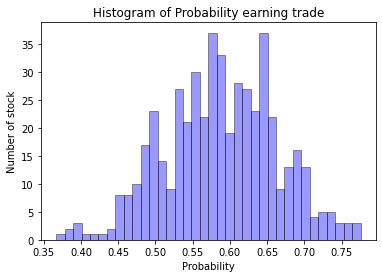

In [77]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# seaborn histogram
sns.distplot(result_data['win_chance'], hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Probability earning trade')
plt.ylabel('Number of stock')
plt.xlabel('Probability')

0.7798901929415291


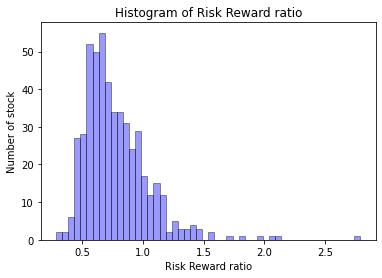

In [82]:
# seaborn histogram
sns.distplot(result_data['Risk Reward ratio'], hist=True, kde=False, 
             bins=int(250/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Histogram of Risk Reward ratio')
plt.ylabel('Number of stock')
plt.xlabel('Risk Reward ratio')
print(result_data['Risk Reward ratio'].mean())

In [43]:
# calculate the return without trailing of hold without sell 
# df_signal['hold_without_sell_return (%)'] = df_signal['Close']/df_signal['Close'].iloc[0]*100
# result['hold_without_sell_return (%)'] = df_signal.set_index('Date')['hold_without_sell_return (%)']

In [83]:
# plot the return and calculate the annualized return and MDD (maximum draw down) for both strategy
# plt.rcParams["figure.figsize"] = (15,6)
# plt.plot(result.Return_without_trailing, label='Return without trailing of SMA20 strategy')
# plt.plot(result['hold_without_sell_return (%)'], label='Return without trailing of hold without sell')
# plt.legend()
# print('Annualized_return of SMA20 strategy:',annualized (result,'Return_without_trailing'))
# print('MDD of SMA20 strategy:', MDD(result,'Return_without_trailing'))

# print('Annualized_return of hold without sell:',annualized (result,'hold_without_sell_return (%)'))
# print('MDD of hold without sell:', MDD(result,'hold_without_sell_return (%)'))